In [1]:
#matplotlib 환경설정
%matplotlib inline

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy

USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
#device = torch.device("cpu")
print("다음 기기로 학습합니다:", device)

cudnn.benchmark = True
plt.ion()   # 대화형 모드

다음 기기로 학습합니다: cuda


**Dataset load**

In [3]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

#zip 파일 현재 폴더로 복사, 중간 부분은 파일명에 따라 변경 필요
!cp /content/drive/MyDrive/food101_tiny.zip ./

Mounted at /content/drive


In [4]:
#압축 해제
!unzip food101_tiny.zip

Archive:  food101_tiny.zip
  inflating: data/food-101-tiny/train/apple_pie/1005649.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1014775.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1026328.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1028787.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1043283.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1050519.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1057749.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1057810.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1072416.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1074856.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1074942.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1076891.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1077610.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1077964.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1088809.jpg  
  inflating: data/food-101-tiny/train/apple

In [5]:
# https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py 참고
# 데이터 증강 및 정규화
# 이미지 데이터셋을 불러오기 전에 데이터 증강 및 정규화에 대한 선언을 먼저 진행
# torchvision.transforms에는 이미지 및 텐서에 적용 가능한 다양한 변환이 있음
# 데이터 증강은 학습 데이터셋에만 적용한다.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([224, 224]),      
        #To-Do: Data augmentation
        transforms.RandomEqualize(0.5), # float가 들어가며 default=0.5
        transforms.RandomHorizontalFlip(), # 수평 반전
        transforms.RandomRotation(degrees=(0,360)),
        #To-Do-end
        transforms.ToTensor()
    ]),
    'valid': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor()
    ]),
}

# ImageFolder 기능을 활용한 PyTorch 데이터셋 및 데이터로더 생성
# torchvision.datasets의 ImageFolder 클래스는 이미지 폴더를 읽어들여 PyTorch dataset으로 변환 (folder_path, transforms 두 종류의 argument를 입력하여 활용 가능)
# dataset 생성 후 미니배치 학습을 위한 데이터로더 또한 생성함
data_dir = 'data/food-101-tiny'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=100,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


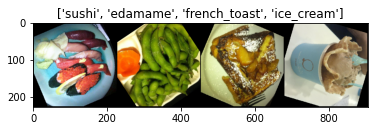

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))    
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

In [11]:
def train_and_eval(model, criterion, optimizer, early_stop_patience = 3):  
    # num_epochs=50
    num_epochs= 50
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    #######
    # patience를 저장하기 위한 변수
    patience = 0
    #######

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다. 
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else: # valid
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 미니 배치 학습 루프
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # 순전파 forward
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}')
            print("patience:", patience+1)

            
            # 모델을 깊은 복사(deep copy)함
            if phase == 'valid' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                patience=0
            elif phase == 'valid' and epoch_accuracy <= best_accuracy:  # valid이지만 정확도는 갱신하지 않는 경우 patience를 증가 시켜준다.
                patience+=1 
            
        # 학습 중지 함수
        if patience >= early_stop_patience:
          print("early stopping이 발생했습니다. 학습을 종료합니다.")
          break;

        print()

    # 정해진 epoch만큼 학습을 수행한 후 검증 데이터셋에서의 성능이 가장 좋은 가중치로 모델을 복구시킨 후 반환
    # 이후 테스트, inference로의 활용 등을 고려한 함수 형태
    
    duration_of_time = time.time() - start_time
    print(f'Training complete time in {duration_of_time // 60:.0f}m {duration_of_time % 60:.0f}s')
    print(f'Best valid Accuracy: {best_accuracy:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [8]:
# 마지막 층을 확인
model_ft = models.vgg16(pretrained=True)
print(model_ft)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
#To-Do: Training and evaluation of vgg16 from scratch
model_ft = models.vgg16(pretrained=False, num_classes = 10) # 이걸 작성해야 한다.
model_ft = model_ft.to(device)

#loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

#model_ft
model_ft = train_and_eval(model_ft, criterion, optimizer_ft, early_stop_patience = 3)

Epoch 0/49
----------
train Loss: 2.3063 Acc: 0.0860
patience: 1
valid Loss: 2.3014 Acc: 0.1280
patience: 1

Epoch 1/49
----------


In [17]:
#To-Do: Training and evaluation of vgg16 from scratch
model_ft = models.vgg16(pretrained=True) # 이걸 작성해야 한다.
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, out_features=10)
model_ft = model_ft.to(device)

#loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

#model_ft
model_ft = train_and_eval(model_ft, criterion, optimizer_ft, early_stop_patience = 3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.8811 Acc: 0.3320
patience: 1
valid Loss: 1.6343 Acc: 0.4500
patience: 1

Epoch 1/49
----------
train Loss: 1.4968 Acc: 0.4620
patience: 1
valid Loss: 1.1237 Acc: 0.6260
patience: 1

Epoch 2/49
----------
train Loss: 1.2862 Acc: 0.5647
patience: 1
valid Loss: 1.2636 Acc: 0.5820
patience: 1

Epoch 3/49
----------
train Loss: 1.2456 Acc: 0.5767
patience: 2
valid Loss: 1.0275 Acc: 0.6280
patience: 2

Epoch 4/49
----------
train Loss: 1.1425 Acc: 0.5973
patience: 1
valid Loss: 0.8806 Acc: 0.6940
patience: 1

Epoch 5/49
----------
train Loss: 0.9138 Acc: 0.6760
patience: 1
valid Loss: 0.7084 Acc: 0.7500
patience: 1

Epoch 6/49
----------
train Loss: 0.8078 Acc: 0.7207
patience: 1
valid Loss: 0.6685 Acc: 0.7840
patience: 1

Epoch 7/49
----------
train Loss: 0.6815 Acc: 0.7700
patience: 1
valid Loss: 0.6264 Acc: 0.8000
patience: 1

Epoch 8/49
----------
train Loss: 0.6685 Acc: 0.7580
patience: 1
valid Loss: 0.7794 Acc: 0.7320
patience: 1

Epoch 9/49
----------
train Loss: 0.7059 

In [14]:
# 마지막 층을 확인
model_ft = models.shufflenet_v2_x2_0(pretrained=True)
print(model_ft)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X2_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X2_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x2_0-8be3c8ee.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x2_0-8be3c8ee.pth


  0%|          | 0.00/28.4M [00:00<?, ?B/s]

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_runn

In [15]:
#Training and evaluation of shufflenet_v2_x2_0 
model_ft = models.shufflenet_v2_x2_0(pretrained=False, num_classes = 10)
model_ft = model_ft.to(device)

#loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

#model_ft
model_ft = train_and_eval(model_ft, criterion, optimizer_ft, early_stop_patience = 3)

Epoch 0/49
----------
train Loss: 2.3485 Acc: 0.0933
patience: 1
valid Loss: 2.3190 Acc: 0.1000
patience: 1

Epoch 1/49
----------
train Loss: 2.3498 Acc: 0.1167
patience: 1
valid Loss: 2.4160 Acc: 0.1000
patience: 1

Epoch 2/49
----------
train Loss: 2.3914 Acc: 0.1007
patience: 2
valid Loss: 2.4703 Acc: 0.1100
patience: 2

Epoch 3/49
----------
train Loss: 2.3582 Acc: 0.1127
patience: 1
valid Loss: 2.3356 Acc: 0.1600
patience: 1

Epoch 4/49
----------
train Loss: 2.2622 Acc: 0.1507
patience: 1
valid Loss: 3.1413 Acc: 0.1340
patience: 1

Epoch 5/49
----------
train Loss: 2.1871 Acc: 0.1867
patience: 2
valid Loss: 2.3385 Acc: 0.1880
patience: 2

Epoch 6/49
----------
train Loss: 2.1537 Acc: 0.1887
patience: 1
valid Loss: 2.0958 Acc: 0.2260
patience: 1

Epoch 7/49
----------
train Loss: 2.1355 Acc: 0.1893
patience: 1
valid Loss: 2.1000 Acc: 0.2300
patience: 1

Epoch 8/49
----------
train Loss: 2.1289 Acc: 0.2000
patience: 1
valid Loss: 2.3757 Acc: 0.2280
patience: 1

Epoch 9/49
--------

In [16]:
# Training and evaluation of shufflenet_v2_x2_0
model_ft = models.shufflenet_v2_x2_0(pretrained=True) 
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

#loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

#model_ft
model_ft = train_and_eval(model_ft, criterion, optimizer_ft, early_stop_patience = 3)

Epoch 0/49
----------
train Loss: 2.1694 Acc: 0.2827
patience: 1
valid Loss: 1.8259 Acc: 0.5740
patience: 1

Epoch 1/49
----------
train Loss: 1.5318 Acc: 0.6293
patience: 1
valid Loss: 1.1030 Acc: 0.7020
patience: 1

Epoch 2/49
----------
train Loss: 0.9770 Acc: 0.7193
patience: 1
valid Loss: 0.6826 Acc: 0.7940
patience: 1

Epoch 3/49
----------
train Loss: 0.7044 Acc: 0.7820
patience: 1
valid Loss: 0.5035 Acc: 0.8580
patience: 1

Epoch 4/49
----------
train Loss: 0.5888 Acc: 0.8020
patience: 1
valid Loss: 0.4859 Acc: 0.8580
patience: 1

Epoch 5/49
----------
train Loss: 0.4664 Acc: 0.8540
patience: 2
valid Loss: 0.4225 Acc: 0.8800
patience: 2

Epoch 6/49
----------
train Loss: 0.3839 Acc: 0.8833
patience: 1
valid Loss: 0.3772 Acc: 0.8840
patience: 1

Epoch 7/49
----------
train Loss: 0.3220 Acc: 0.9027
patience: 1
valid Loss: 0.4048 Acc: 0.8880
patience: 1

Epoch 8/49
----------
train Loss: 0.2709 Acc: 0.9173
patience: 1
valid Loss: 0.3720 Acc: 0.8820
patience: 1

Epoch 9/49
--------